# **1. Loading Data**


## **1.1 Importing libraries**

In [257]:
# Importing libraries for datasets manipulation and exploration
import pandas as pd
from nltk.corpus import stopwords
import re
from unidecode import unidecode

# Importing libraries for graphs plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import geobr

# Importing libraries to hide Future Warnings
import warnings
warnings.filterwarnings('ignore')

## **1.2 Loading dataset**

In [258]:
df = pd.read_csv('linkedin_scraping.csv', sep=";")
df = df.dropna()
df.rename(columns={'Unnamed: 0': 'index'}, inplace=True)

# **2. Data wrangling**

## **2.1 Auxiliary functions**

In [259]:
## Creating functions to prepare the strings
# Function to remove special caracters
def cleanse(row):
    row_clean = row.replace("_", " ")
    row_clean = re.sub("[.!?/\()-,:#']", "",row_clean)
    row_clean = row_clean.lower()
    return row_clean

# Function to remove stopwords in pt-br and en-us
def stop_words_df(df):
    stop_pt = stopwords.words('portuguese')
    stop_en = stopwords.words('english')
    clean_stop_pt = lambda x: ' '.join([word for word in x.split() if word not in (stop_pt)])
    clean_stop_en = lambda x: ' '.join([word for word in x.split() if word not in (stop_en)])
    df['description_clean'] = df['description'].apply(clean_stop_en)
    df['description_clean'] = df['description_clean'].apply(clean_stop_pt)
    return df

In [260]:
# Create function to count the words in each description
def text_count(df, column):
    text_dict = {}
    for index, row in df.iterrows():   
        text = row[column].split(" ")
        for word in text:
            if text != " ":
                if word.lower() not in text_dict.keys():
                    text_dict.update({f"{word.lower()}":1})
                else:
                    text_dict[f"{word.lower()}"]+=1
    return text_dict

## **2.2 Data preparation**

In [261]:
# Removing duplicate values
df.drop_duplicates(subset=['description', 'company', 'location'], inplace = True)

In [262]:
# Creating two columns (City, State) to better understand the information presented on the dataset
df[['City', 'State', 'Country']] = df['location'].str.split(',', expand=True)
df.drop(columns=['Country'], inplace = True)
df[['City', 'State']] = df[['City', 'State']].apply(lambda x: x.str.lower())
df['State'] = df['State'].str.strip()
df['City'] = df['City'].str.strip()
df['City'] = df['City'].str.replace(" e regiao", "")

In [263]:
# Moving values to its corresponding columns
results = {'index': [],
           'state': [],
           'city' : []}
for index, row in df[['index', 'City', 'State']].iterrows():
    if row['City'] in list(df['State'].unique()):
        index = row['index']
        City = None
        State = row['City']
    else:
        index = row['index']
        City = row['City']
        State = row['State']
    results['index'].append(index)
    results['state'].append(State)
    results['city'].append(City)

results = pd.DataFrame.from_dict(data = results)
df = pd.merge(df, results, on='index', how='outer')
df.drop(columns=['City', 'State'], inplace=True)

In [264]:
# Creating a column to the region of each state, and renaming some "None" values
regioes = {'acre': 'Norte',
    'alagoas': 'Nordeste',
    'amapa': 'Norte',
    'amazonas': 'Norte',
    'bahia': 'Nordeste',
    'ceara': 'Nordeste',
    'distrito federal': 'Centro-Oeste',
    'espirito santo': 'Sudeste',
    'goias': 'Centro-Oeste',
    'maranhao': 'Nordeste',
    'mato grosso': 'Centro-Oeste',
    'mato grosso do sul': 'Centro-Oeste',
    'minas gerais': 'Sudeste',
    'para': 'Norte',
    'paraiba': 'Nordeste',
    'parana': 'Sul',
    'pernambuco': 'Nordeste',
    'piaui': 'Nordeste',
    'rio de janeiro': 'Sudeste',
    'rio grande do norte': 'Nordeste',
    'rio grande do sul': 'Sul',
    'rondonia': 'Norte',
    'roraima': 'Norte',
    'santa catarina': 'Sul',
    'sao paulo': 'Sudeste',
    'sergipe': 'Nordeste',
    'tocantins': 'Norte'
}

cidades = {
    'campinas': 'sao paulo',
    'porto alegre': 'rio grande do sul',
    'belem': 'para',
    'curitiba': 'parana',
    'joao pessoa': 'paraiba',
    'brasilia': 'distrito federal',
    'florianopolis': 'santa catarina',
    'goiania': 'goias',
    'belo horizonte': 'minas gerais',
    'recife': 'pernambuco'
}

df_nan = df.loc[df['state'].isna()==True]
df.dropna(axis = 0, subset=['state'], inplace = True)
df_nan['state'] = df_nan['city'].map(cidades)
df = pd.concat([df, df_nan])
df['region'] = df['state'].map(regioes)


In [265]:
# Removing special characters and stopwords from the "description" column
df['description'] = df['description'].apply(cleanse)
df = stop_words_df(df)
df['description_clean'] = df['description_clean'].astype(str)

In [266]:
# Counting words
text_dict = text_count(df, 'description_clean')
word_count_qual = pd.DataFrame(text_dict,index = [0]).rename(index = {0:'Word_Count'}).transpose()
word_count_qual=word_count_qual.sort_values(by=word_count_qual.columns[0],ascending=False)

# **3. Words overview**

## **3.1 Auxiliary function**

In [267]:
def plot_word_count(word_count_qual, subset_description = ''):
    fig, (ax1) = plt.subplots(figsize=(8, 5))
    custom_lines_1 = [Line2D([0], [0], lw=1.5,color = 'red'),Line2D([0], [0], lw=4, alpha=0)]
    word_count_qual.plot(ax = ax1, rot=45,color = 'red')
    ax1.set_title(f"Description Counts {subset_description}",pad=20,fontdict = {'fontsize' : 15,'fontweight':1000})
    ax1.legend(custom_lines_1,[f'Word Count',f'Mean word count is {word_count_qual.mean()[0]:.2f}\nWith a maximum of {word_count_qual.max()[0]:.0f} \nWith a minimum of {word_count_qual.min()[0]:.0f}'])
    plt.show()

## **3.2 Words visualization**

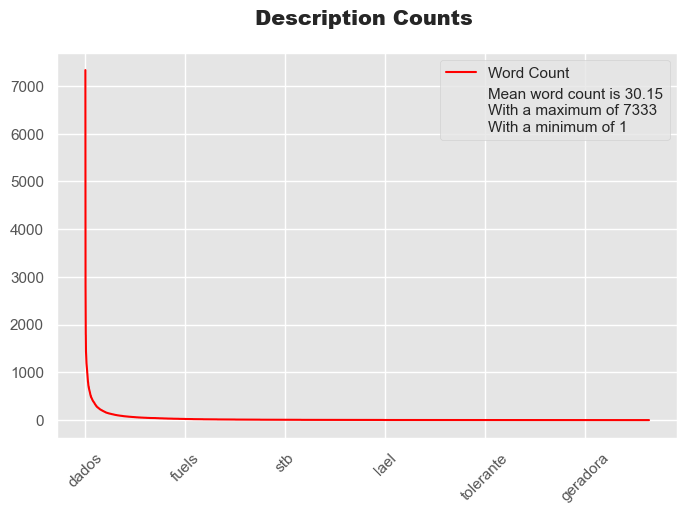

In [268]:
plot_word_count(word_count_qual)

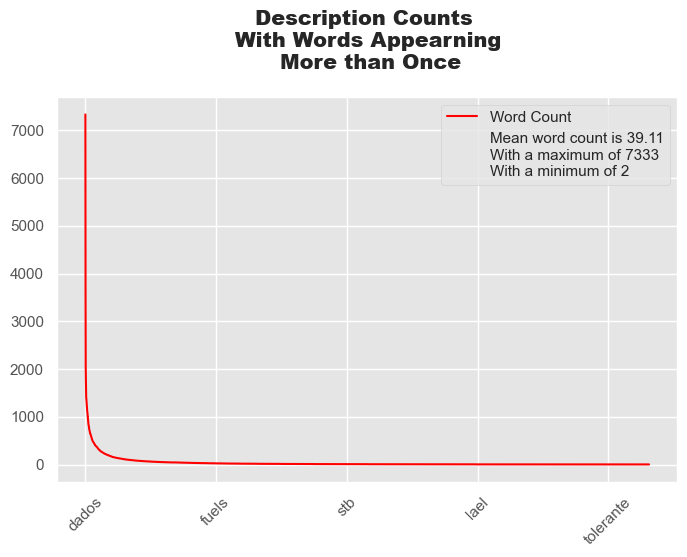

In [269]:
more_than_one_qual = word_count_qual[word_count_qual.Word_Count > 1]
plot_word_count(more_than_one_qual, subset_description="\nWith Words Appearning\n More than Once")

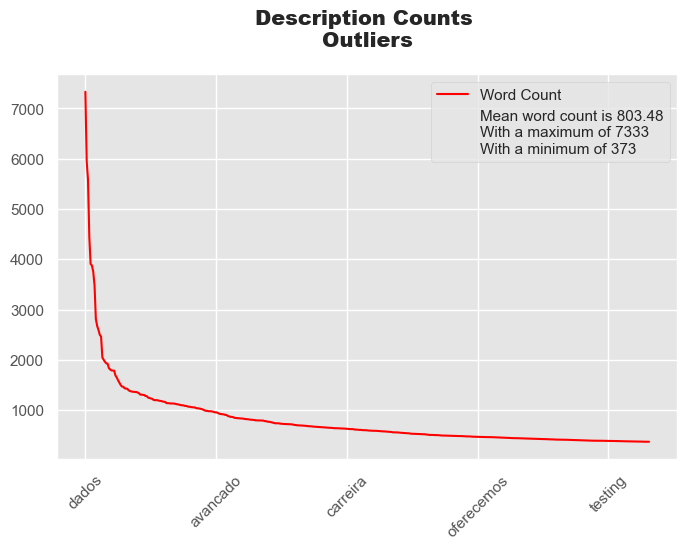

In [270]:
outliers_qual = more_than_one_qual[more_than_one_qual > more_than_one_qual.quantile(.98)[0]].dropna()
plot_word_count(outliers_qual,subset_description='\nOutliers')

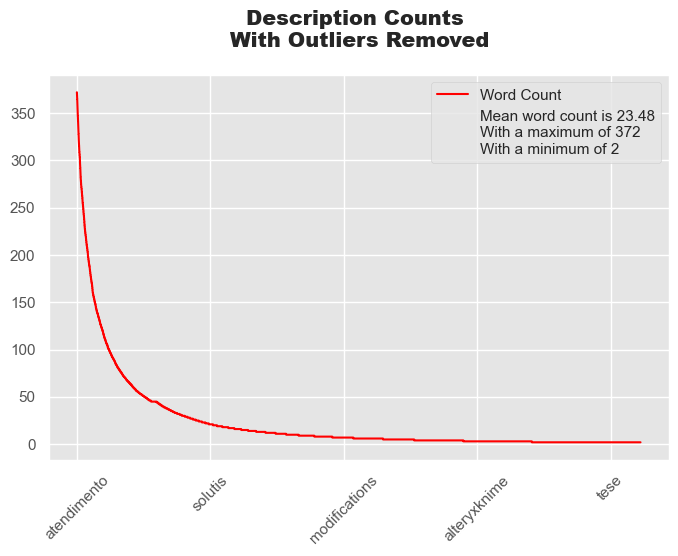

In [271]:
remove_out_qual = more_than_one_qual[more_than_one_qual < more_than_one_qual.quantile(.98)[0]].dropna()
plot_word_count(remove_out_qual,subset_description="\nWith Outliers Removed")

# **4. Jobs description and geoloc overview**

## **4.1 Auxiliary functions**

In [272]:
# Function to create a dataframe with the top 5 most common words
def countingKeywords(lista, word_count_qual, column_name = '', top=5):    
    data = {column_name: lista}
    data = pd.DataFrame(data)
    data[column_name] = data[column_name].str.lower()
    word_count_qual['words'] = word_count_qual.index
    keywords_df = word_count_qual[word_count_qual['words'].isin(data[column_name])]
    keywords_df = keywords_df.sort_values(by='Word_Count', ascending=False)
    top_keywords_df = keywords_df.head(top)
    return top_keywords_df

In [273]:
def plotStats(data_science_tools, names, dataframe, title=''):
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

    # Número de colunas
    number_of_columns = 6

    # Criando figura que irá comportar os gráficos
    if title=='':
        fig = plt.figure(figsize=(21, 2))
        fig.tight_layout()

    else:
        fig = plt.figure(figsize=(21, 2))
        fig.tight_layout()
        fig.suptitle(title, fontsize=14, y=1.2)
        
    # Loop para criação dos gráficos das features escolhidas
    for index, tool in enumerate(data_science_tools, 1):
        top_keywords_df = countingKeywords(tool, dataframe, column_name = f'{tool}', top=5)

        # Criando subplot
        ax = fig.add_subplot(1, number_of_columns, index)
        sns.barplot(x = 'Word_Count', y = 'words', data = top_keywords_df, color= colors[index])
        fig.subplots_adjust(hspace=0.2)
        fig.subplots_adjust(wspace=0.6)

        # Definindo título
        ax.set_title(f'{names[index]}', fontsize=12, loc='center')
        ax.bar_label(ax.containers[0], label_type='center', color='white')

        # Eliminando partes do frame no gráfico
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)   
        ax.set(xlabel=None) 
        ax.set(ylabel=None) 
        ax.axes.get_xaxis().set_visible(False)

In [274]:
def creatingCountDataframe(dataframe, col):
    df_count = pd.DataFrame([])
    for variable in list(dataframe[col].unique()):
        df_new = df.loc[dataframe[col]==variable]
        text_dict = text_count(df_new , 'description_clean')
        word_count = pd.DataFrame(text_dict, index = [0]).rename(index = {0:'Word_Count'}).transpose()
        word_count[col] = variable
        df_count = pd.concat([df_count, word_count])
    df_count = df_count.sort_values(by=df_count.columns[0],ascending=False)
    return df_count

In [311]:
def plotDonutChart(dataframe, variable, title=''):
        # Colors
        cores = ['#4586AC', '#FFF000', '#CC5A49']

        # Creating Dataframe
        top_keywords_df = countingKeywords(variable, dataframe, column_name = f'{variable}', top=10)

                # Remaping words 
        educ_dic = {'superior': 'bachelors',
        'mestrado': 'masters',
        'doutorado': 'doctorate',
        'bachelors': 'bachelors',
        'masters': 'masters',
        'doctorate': 'doctorate',
        'doctors': 'doctorate'}

        top_keywords_df['words'] = top_keywords_df['words'].map(educ_dic)
        top_keywords_df = top_keywords_df.groupby('words')['Word_Count'].sum().reset_index()

        # Creating figure
        if title=='':
            fig = plt.figure()
            fig.tight_layout()

        else:
            fig = plt.figure()
            fig.tight_layout()
            fig.suptitle(title, fontsize=14, y=1)

        # Creating subplot
        _wedges, labels, percentages = plt.pie(x = 'Word_Count', labels='words', data = top_keywords_df,
                autopct='%1.2f%%', startangle=90, counterclock=False, textprops={'fontsize': 10}, colors=cores)

        # Creating labels
        for label, percentage in zip(labels, percentages):
            label.set_text(label.get_text() + '\n' + percentage.get_text())
            percentage.remove()
        
        # Adding a circle at the center to transform it in a donut chart
        my_circle=plt.Circle( (0,0), 0.7, color='white')
        p=plt.gcf()
        p.gca().add_artist(my_circle)

        plt.show()

In [276]:
def plotMultipleVars(dataframe, col, names, lista):
    for variable in list(dataframe[col].unique()):
        df_var = dataframe.loc[dataframe[col]==variable]
        if len(df_var.index) >> 0:
            try:
                text_dict_var = text_count(df_var, 'description_clean')
                word_count_qual_var = pd.DataFrame(text_dict_var, index = [0]).rename(index = {0:'Word_Count'}).transpose()
                word_count_qual_var = word_count_qual_var.sort_values(by=word_count_qual_var.columns[0],ascending=False)
                plotStats(lista, names, word_count_qual_var, title=f'{variable} / n: {len(df_var.index)}')
            except:
                continue
        
        else:
            continue

In [277]:
# Lists of most used tools in Data careers
programming_languages = ["Python", "Java", "JavaScript", "C", 
                         "C++", "C#", "PHP", "Ruby", "Swift", "R", 
                         "Kotlin", "Go", "Scala", "Perl", "MATLAB",
                         "Visual Basic", "Assembly", "TypeScript", "Lua", "Haskell", 
                         "Dart", "Rust", "Julia", "F#", "Groovy", "COBOL", "Fortran", 
                         "PowerShell", "Scheme", "Smalltalk", "Erlang", "Lisp", "Prolog", 
                         "Ada", "VBScript", "ActionScript", "Scratch", "Logo", "BASIC", "Pascal"]

data_science_packages = ["NumPy", "Pandas", "SciPy", "scikit",
                         "Keras", "TensorFlow", "PyTorch", "NLTK", 
                         "Spacy", "Gensim", "XGBoost", 
                         "LightGBM", "CatBoost", "statsmodels", "opencv", "Matplotlib", "Seaborn", "Plotly", 'ggplot']

data_viz = ["PowerBI", "Tableau", "Looker", "mixpanel", "cognos", "salesforce", "geckoboard"]

data_science_cloud = ["AWS", "SQL", "GCP", "Azure", "BigQuery", "Apache", "MySQL", "SQLite"
                      "Databricks", "Snowflake", "Qubole", "Git", "Kubernetes", 
                      "NoSQL", "SQLite", "PySpark", "Spark", "Docker", "Hadoop"]

education = ["Mestrado", "superior", "bachelors", "Masters", "Doutorado", "Doctors", "Doctorate"]

data_all = programming_languages + data_science_cloud + data_science_packages + data_viz

data_science_tools = [programming_languages, data_science_cloud, data_science_packages, data_viz, data_all]
names = ['', 'programming_languages', 'clustering_cloud_database', 'data_science_packages', 'data_viz', 'data_all']

## **4.2 Geoloc overview**

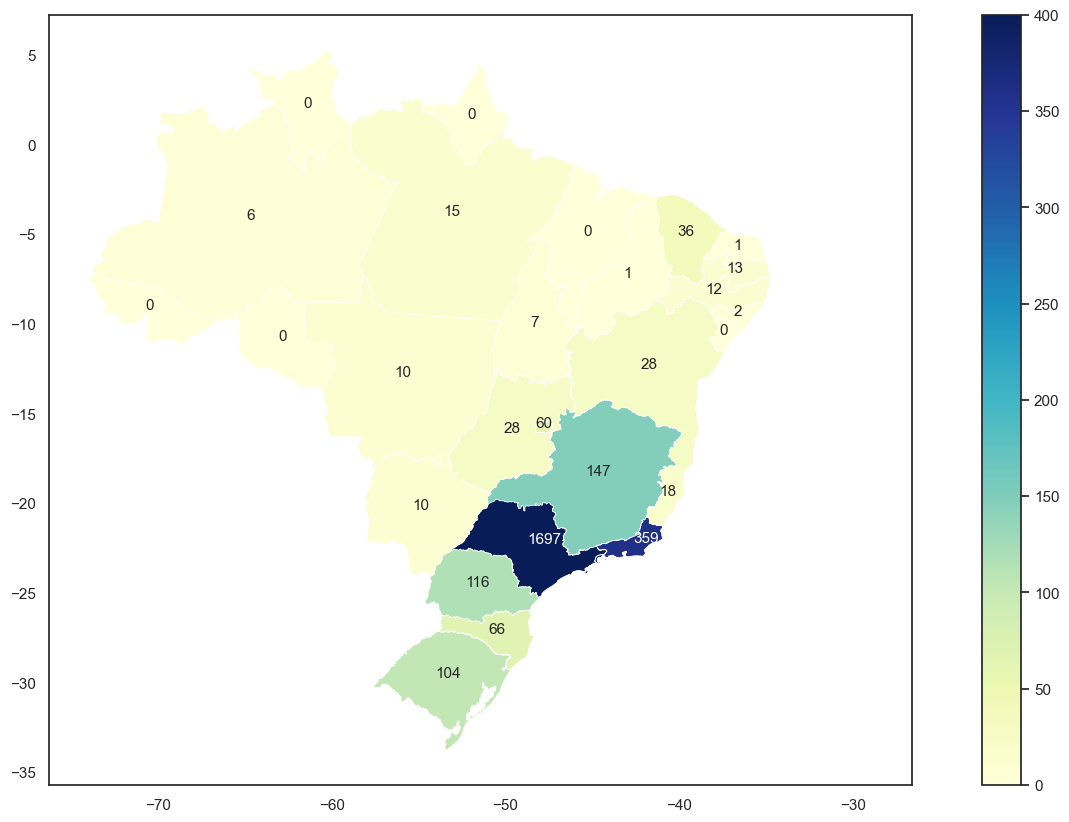

In [279]:
uf_info = geobr.read_country(2020)
uf_info[['state', 'region']] = uf_info[['name_state', 'name_region']].apply(lambda x: x.str.lower())
uf_info['state'] = uf_info['state'].apply(lambda x: unidecode(x))


df_jobs_state = df['state'].value_counts().to_frame().reset_index()
df_jobs_state.columns = ['state', 'Job Count']
df_jobs_state = df_jobs_state.loc[df_jobs_state['state'] != 'brasil']

geo_brasil = uf_info.merge(df_jobs_state, on='state', how='left').fillna(0)
geo_brasil['Job Count'] = geo_brasil['Job Count'].astype(int)

sns.set(font_scale=1)
sns.set_style('white')

geo_brasil.plot(
    column='Job Count', figsize=(18,10), legend=True, cmap='YlGnBu', vmin=0, vmax=400,
    linewidth=0.5)

for ix, r in geo_brasil.iterrows():
    if r['Job Count'] >= 150:
        plt.annotate(
            text=r['Job Count'], xy=r.geometry.centroid.coords[0], horizontalalignment='left', fontsize=11, color='white'
        )
    else:
        plt.annotate(
            text=r['Job Count'], xy=r.geometry.centroid.coords[0], horizontalalignment='center', fontsize=11
        )

plt.show()

In [280]:
df_jobs_state['percent'] = df_jobs_state['Job Count'] / df_jobs_state['Job Count'].sum() * 100
df_jobs_state

,state,Job Count,percent
0,sao paulo,1697,62.024854
2,rio de janeiro,359,13.121345
3,minas gerais,147,5.372807
4,parana,116,4.239766
5,rio grande do sul,104,3.801170
6,santa catarina,66,2.412281
7,distrito federal,60,2.192982
8,ceara,36,1.315789
9,goias,28,1.023392
10,bahia,28,1.023392


In [281]:
df_jobs_region = df['region'].value_counts().to_frame().reset_index()
df_jobs_region.columns = ['region', 'Job Count']
df_jobs_region['percent'] = df_jobs_region['Job Count'] / df_jobs_region['Job Count'].sum() * 100
df_jobs_region

,region,Job Count,percent
0,Sudeste,2221,81.176901
1,Sul,286,10.453216
2,Centro-Oeste,108,3.947368
3,Nordeste,93,3.399123
4,Norte,28,1.023392


In [282]:
df_jobs_state = df['state'].value_counts().to_frame().reset_index()
df_jobs_state.columns = ['state', 'Job Count']
df_jobs_state = df_jobs_state.loc[(df_jobs_state['state'] != 'sao paulo') & (df_jobs_state['state'] != 'brasil')]
df_jobs_state['percent'] = df_jobs_state['Job Count'] / df_jobs_state['Job Count'].sum() * 100
df_jobs_state

,state,Job Count,percent
2,rio de janeiro,359,34.552454
3,minas gerais,147,14.148219
4,parana,116,11.164581
5,rio grande do sul,104,10.009625
6,santa catarina,66,6.352262
7,distrito federal,60,5.774783
8,ceara,36,3.464870
9,goias,28,2.694899
10,bahia,28,2.694899
11,espirito santo,18,1.732435


In [283]:
df_jobs_region = df.loc[(df['state'] != 'sao paulo') & (df['state'] != 'brasil')]
df_jobs_region = df_jobs_region['region'].value_counts().to_frame().reset_index()
df_jobs_region.columns = ['region', 'Job Count']
df_jobs_region['percent'] = df_jobs_region['Job Count'] / df_jobs_region['Job Count'].sum() * 100
df_jobs_region

,region,Job Count,percent
0,Sudeste,524,50.433109
1,Sul,286,27.526468
2,Centro-Oeste,108,10.394610
3,Nordeste,93,8.950914
4,Norte,28,2.694899


81% dos anúncios de emprego vieram da região Sudeste. Sendo concentrado no estado de São Paulo o maior número dessas vagas ()

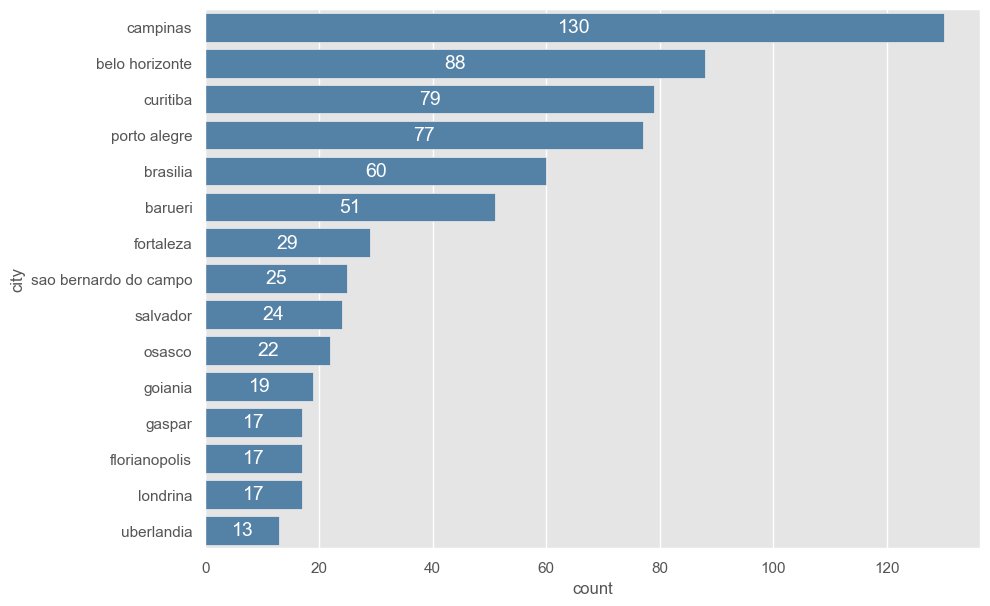

In [284]:
plt.style.use('ggplot')
city_counts = df['city'].value_counts().to_frame().reset_index()
city_counts.columns = ['city', 'count']
fig, ax = plt.subplots(figsize=(10, 7))
sns.barplot(x = 'count', y = 'city', data = city_counts.head(15), color='steelblue')
ax.bar_label(ax.containers[0], label_type='center', color='white', fontsize=14)
plt.show()

In [285]:
jo_dic = {'data scientist': 'data scientist',
          'data scientist jr': 'data scientist',
          'data analyst': 'data analyst',
          'data analyst jr': 'data analyst',
          'data engineer': 'data engineer',
          'data engineer jr': 'data engineer'}

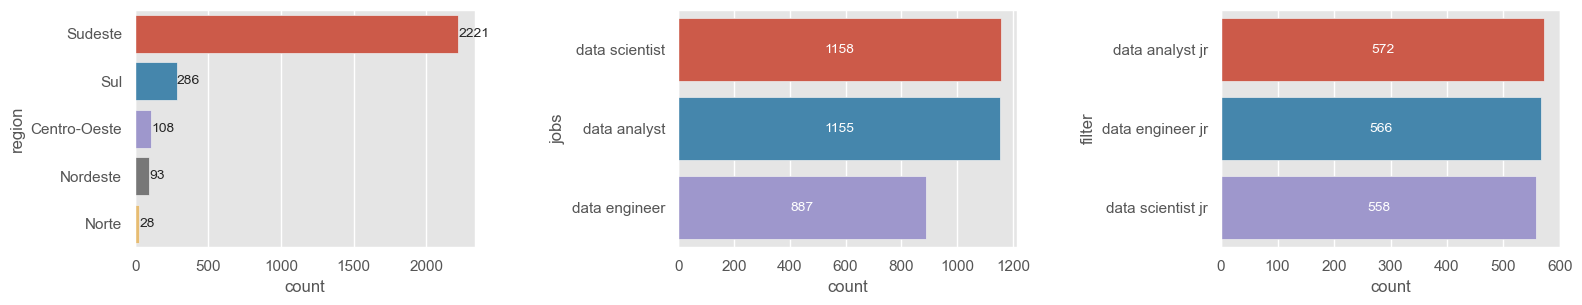

In [286]:
fig, axes = plt.subplots(1,3, figsize=(15, 3))
fig.tight_layout()
df['jobs'] = df['filter'].map(jo_dic)
df_jobs_jr = df.loc[(df['filter'] == 'data scientist jr') | (df['filter'] == 'data analyst jr') | (df['filter'] == 'data engineer jr')]


sns.countplot(data=df, y="region", order = df['region'].value_counts().index, ax=axes[0])
sns.countplot(data=df, y="jobs", order = df['jobs'].value_counts().index, ax=axes[1])
sns.countplot(data=df, y="filter", order = df_jobs_jr['filter'].value_counts().index, ax=axes[2])
fig.subplots_adjust(hspace=0.2)
fig.subplots_adjust(wspace=0.6)

axes[0].bar_label(axes[0].containers[0], label_type='edge')
axes[1].bar_label(axes[1].containers[0], label_type='center', color='white')
axes[2].bar_label(axes[2].containers[0], label_type='center', color='white')

plt.show()

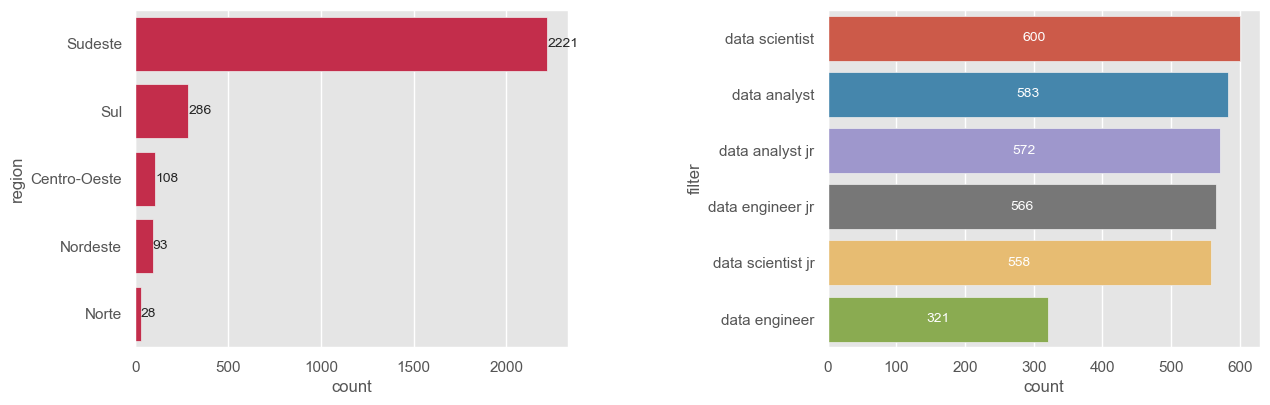

In [287]:
fig, axes = plt.subplots(1,2, figsize=(12, 4))
fig.tight_layout()
df['jobs'] = df['filter'].map(jo_dic)
df_jobs_jr = df.loc[(df['filter'] == 'data scientist jr') | (df['filter'] == 'data analyst jr') | (df['filter'] == 'data engineer jr')]


sns.countplot(data=df, y="region", order = df['region'].value_counts().index, ax=axes[0], color='crimson')
sns.countplot(data=df, y="filter", order = df['filter'].value_counts().index, ax=axes[1])
#sns.countplot(data=df, y="filter", order = df_jobs_jr['filter'].value_counts().index, ax=axes[2])
fig.subplots_adjust(hspace=0.2)
fig.subplots_adjust(wspace=0.6)

axes[0].bar_label(axes[0].containers[0], label_type='edge')
axes[1].bar_label(axes[1].containers[0], label_type='center', color='white')
#axes[2].bar_label(axes[2].containers[0], label_type='center', color='white')

plt.show()

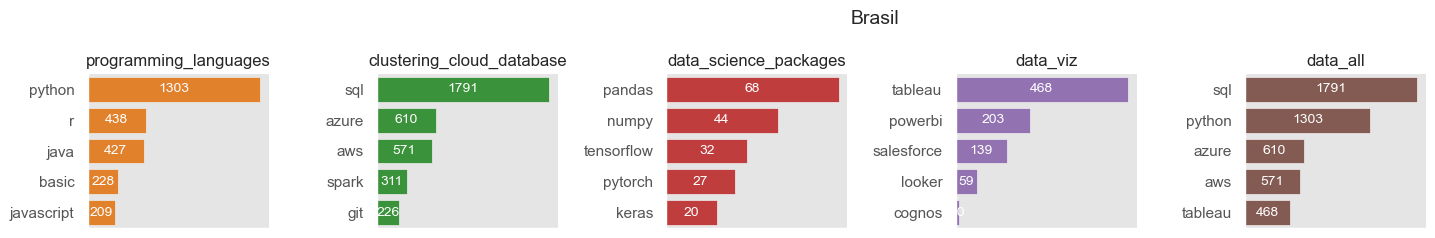

In [288]:
# General country view
plotStats(data_science_tools, names, word_count_qual, title='Brasil')

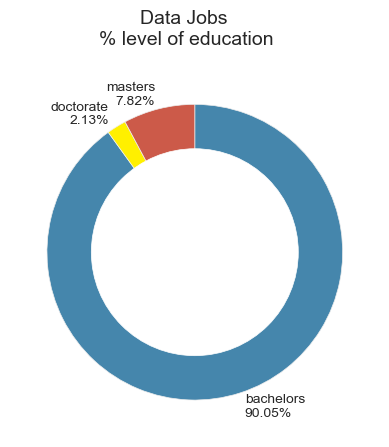

In [321]:
plotDonutChart(word_count_qual, education, title = 'Data Jobs \n% level of education')

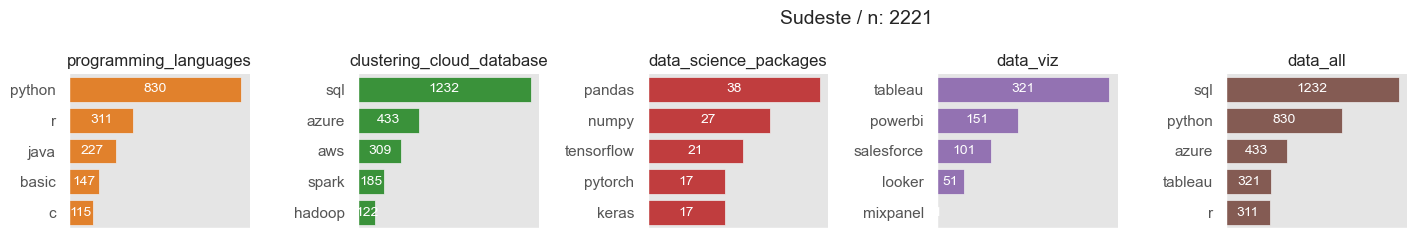

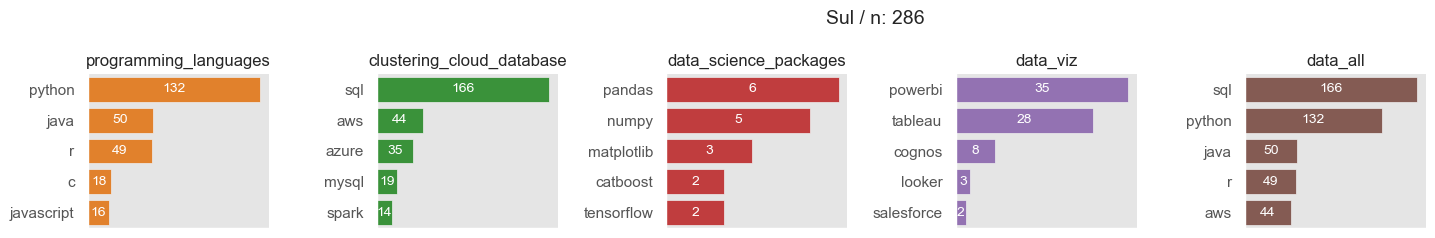

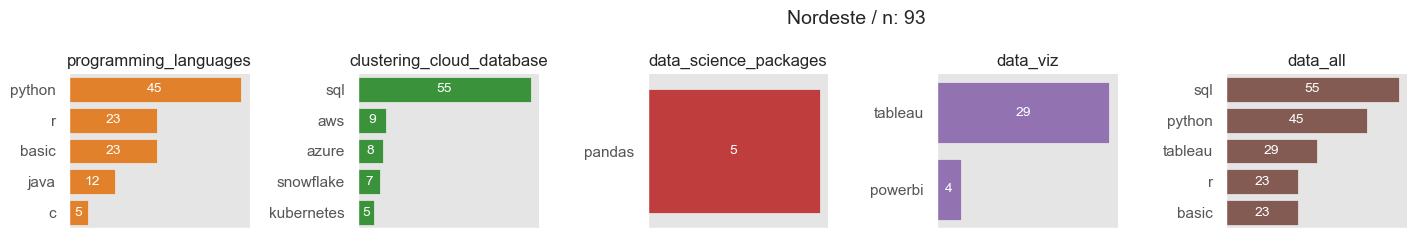

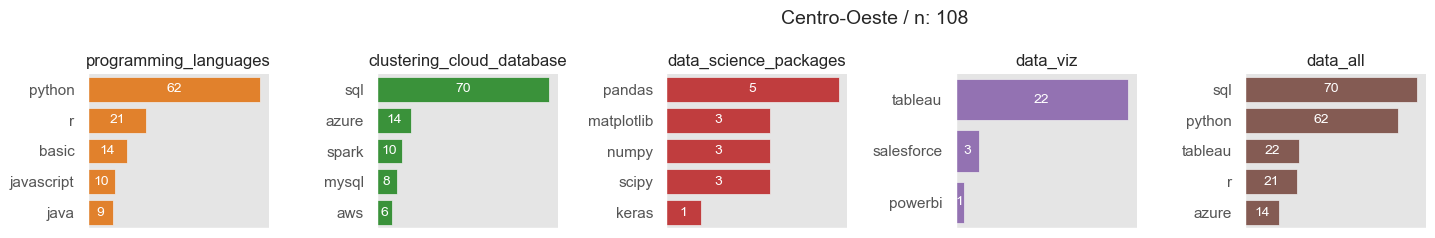

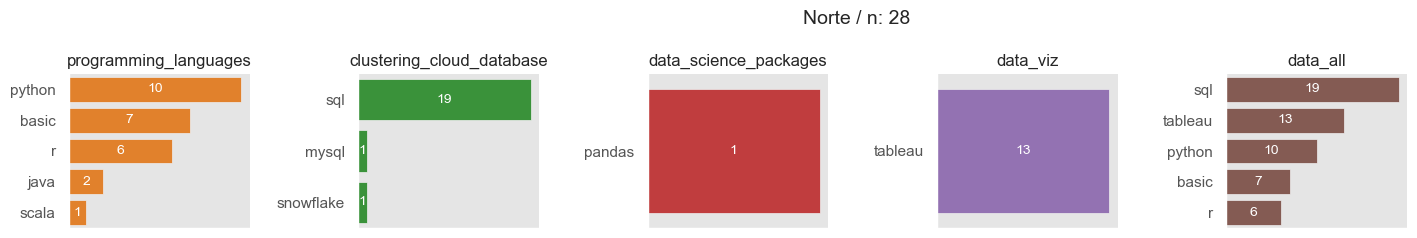

In [290]:
# View of each region
plotMultipleVars(df, 'region', names, data_science_tools)

## **4.3 Jobs description overview**

### **4.3.1 Data Scientist**

In [291]:
# Filtering dataframe
df_data_scientist = df.loc[(df['filter']=='data scientist') | (df['filter']=='data scientist jr')]
text_dict_ds = text_count(df_data_scientist, 'description_clean')

# Counting words
word_count_qual_ds = pd.DataFrame(text_dict_ds, index = [0]).rename(index = {0:'Word_Count'}).transpose()
word_count_qual_ds = word_count_qual_ds.sort_values(by=word_count_qual_ds.columns[0],ascending=False)

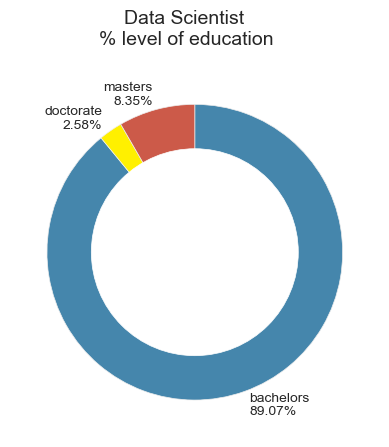

In [318]:
plotDonutChart(word_count_qual_ds, education, title = 'Data Scientist \n% level of education')

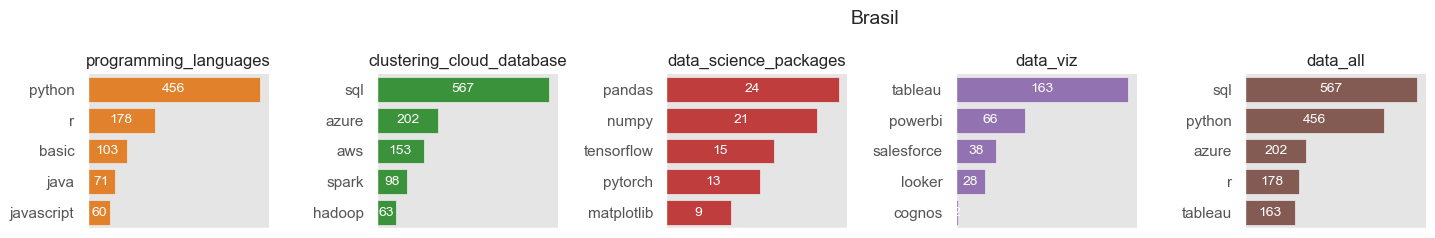

In [292]:
# General country view
plotStats(data_science_tools, names, word_count_qual_ds, title='Brasil')

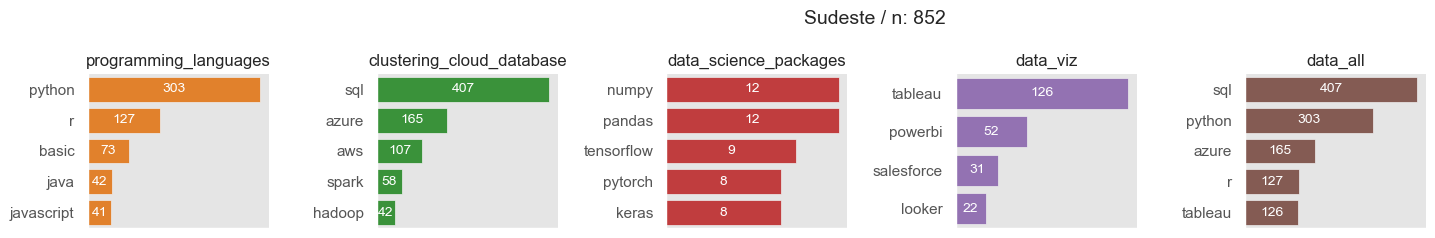

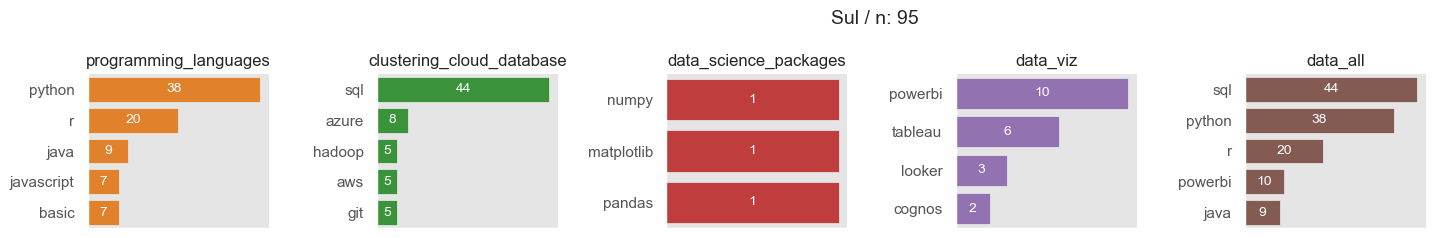

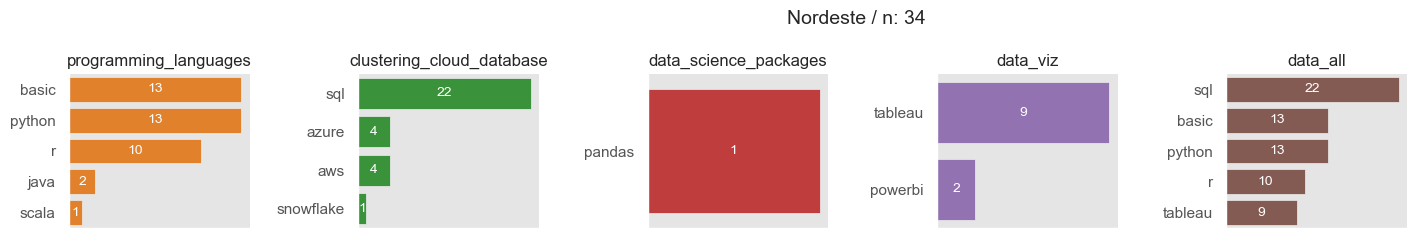

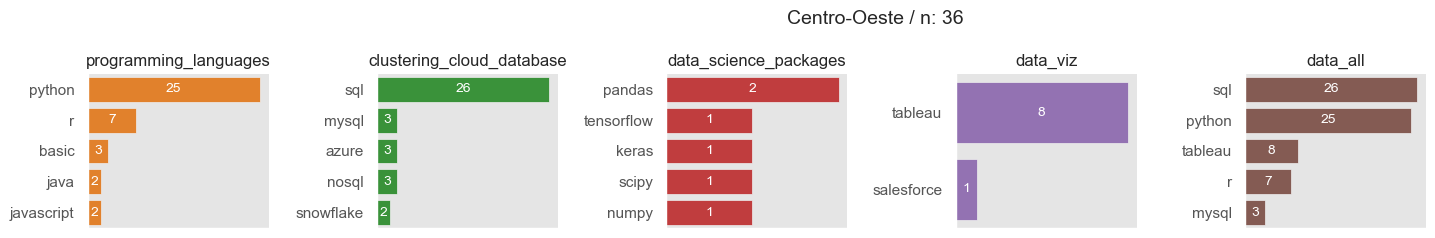

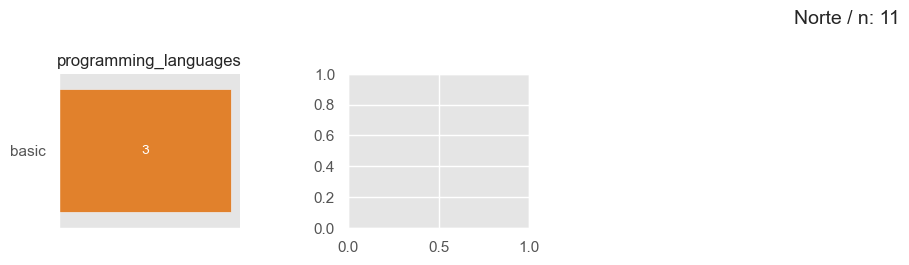

In [293]:
# View of each region
plotMultipleVars(df_data_scientist, 'region', names, data_science_tools)

### **4.3.2 Data Analyst**

In [294]:
# Filtering dataframe
df_data_analyst = df.loc[(df['filter']=='data analyst') | (df['filter']=='data analyst jr')]
text_dict_da = text_count(df_data_analyst, 'description_clean')

# Counting words
word_count_qual_da = pd.DataFrame(text_dict_da, index = [0]).rename(index = {0:'Word_Count'}).transpose()
word_count_qual_da = word_count_qual_da.sort_values(by=word_count_qual_da.columns[0],ascending=False)

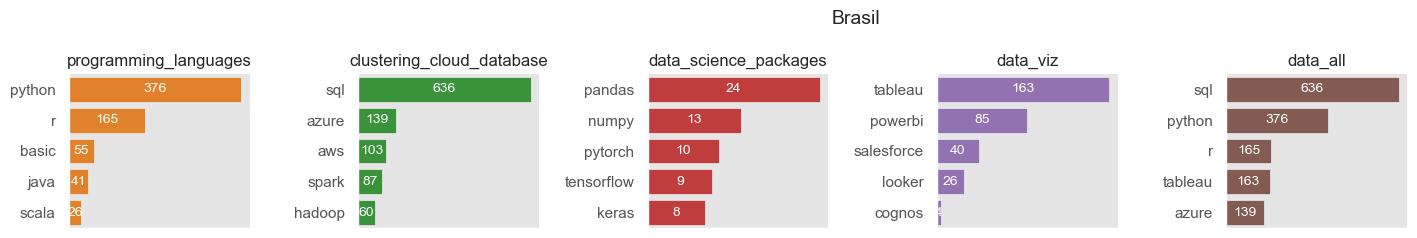

In [295]:
# General country view
plotStats(data_science_tools, names, word_count_qual_da, title='Brasil')

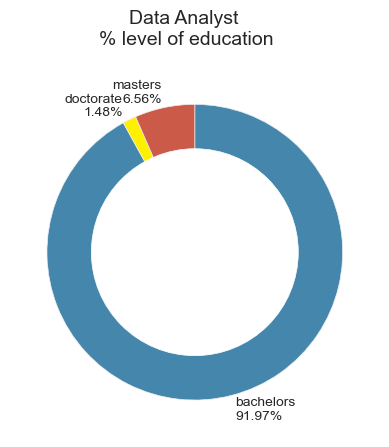

In [319]:
plotDonutChart(word_count_qual_da, education, title = 'Data Analyst \n% level of education')

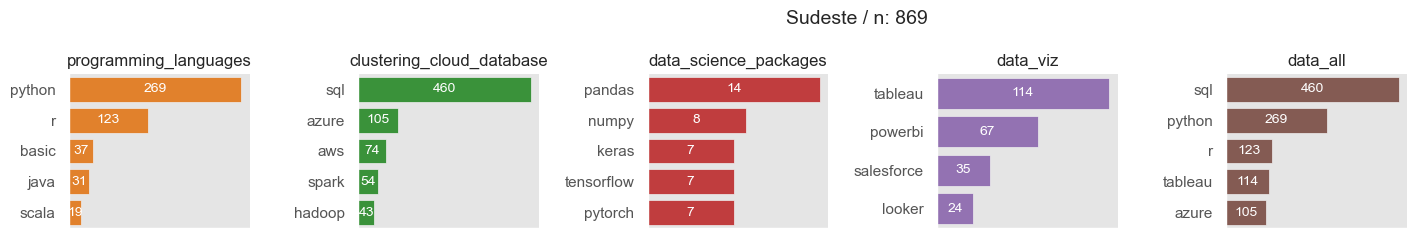

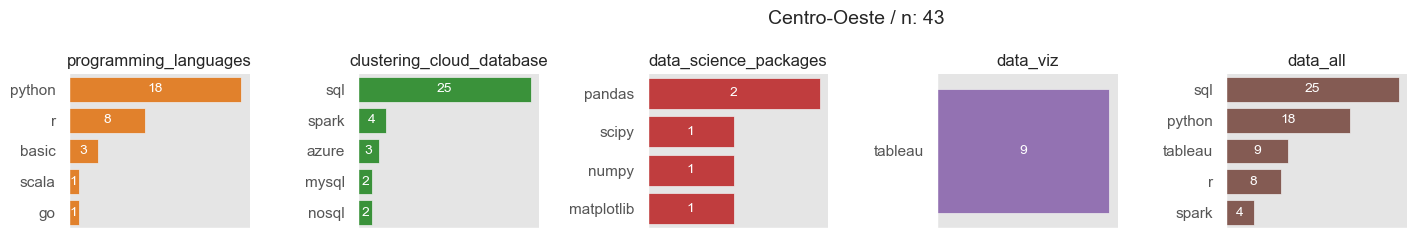

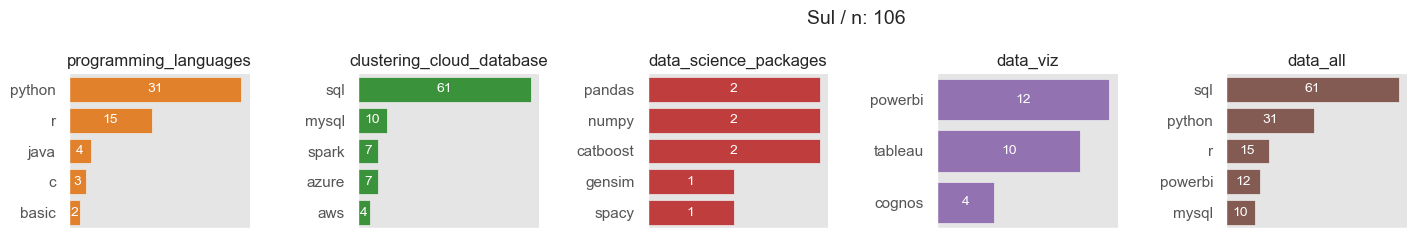

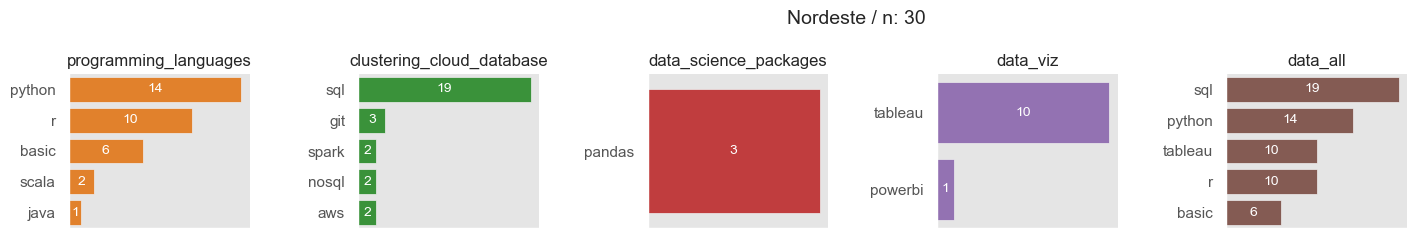

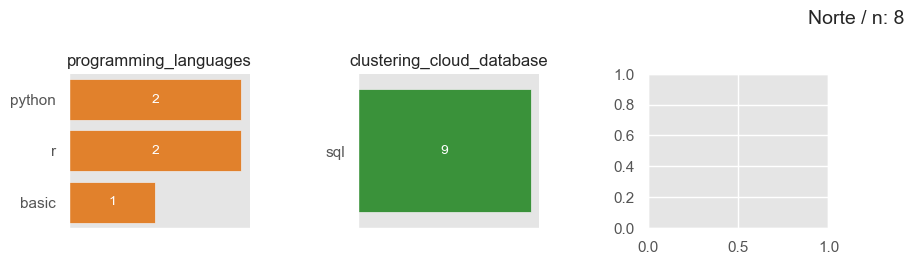

In [296]:
# View of each region
plotMultipleVars(df_data_analyst, 'region', names, data_science_tools)

### **4.3.3 Data Engineer**

In [297]:
# Filtering dataframe
df_data_engineer = df.loc[(df['filter']=='data engineer') | (df['filter']=='data engineer jr')]
text_dict_de = text_count(df_data_engineer, 'description_clean')

# Counting words
word_count_qual_de = pd.DataFrame(text_dict_de, index = [0]).rename(index = {0:'Word_Count'}).transpose()
word_count_qual_de = word_count_qual_de.sort_values(by=word_count_qual_de.columns[0],ascending=False)

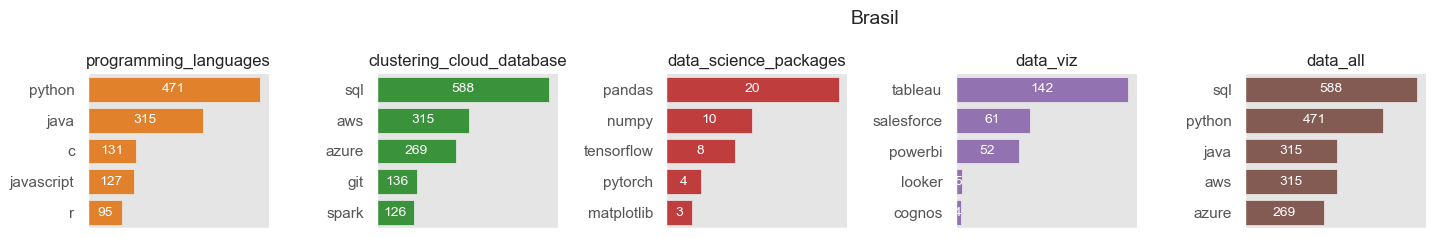

In [298]:
# General country view
plotStats(data_science_tools, names, word_count_qual_de, title='Brasil')

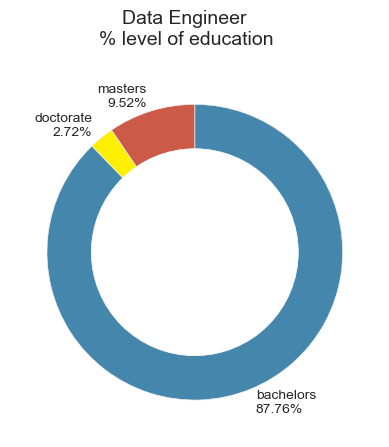

In [320]:
plotDonutChart(word_count_qual_de, education, title = 'Data Engineer \n% level of education')

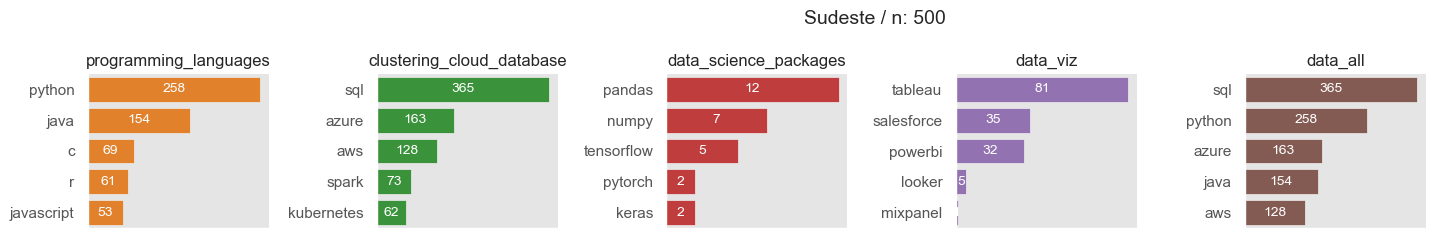

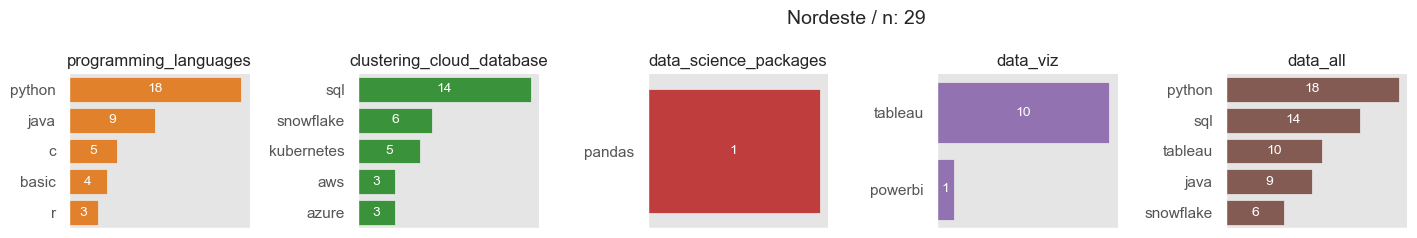

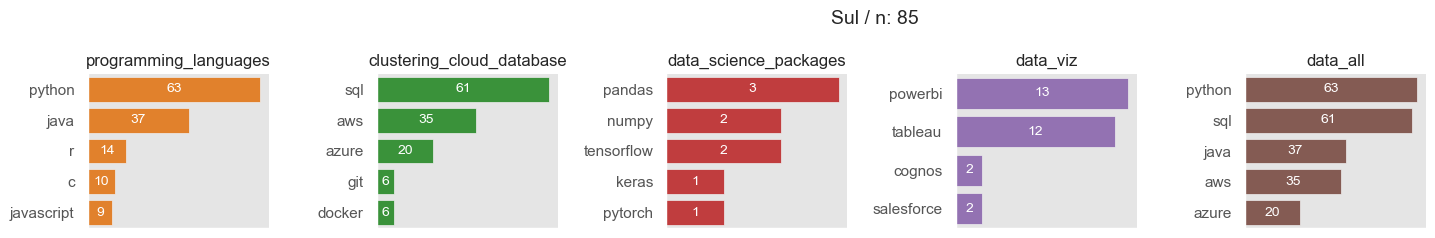

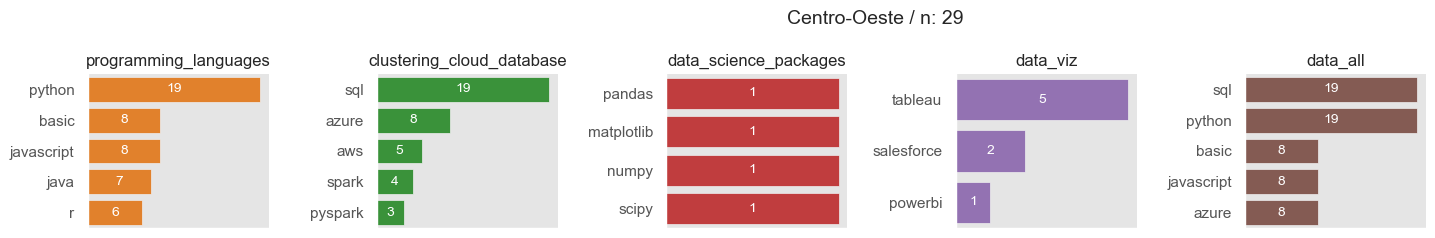

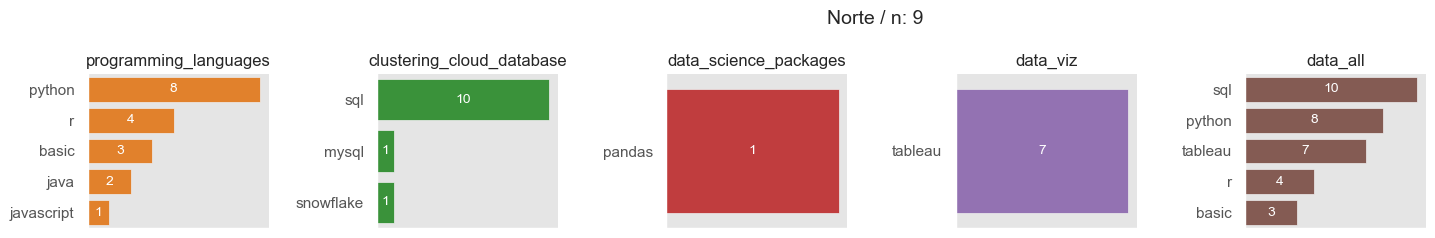

In [299]:
# View of each region
plotMultipleVars(df_data_engineer, 'region', names, data_science_tools)